${\Huge \text{GroupFold Cross Validation - artefact classification}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook aims to perform rigorous cross-validation by testing the model (fixed algorithm, fixed set of features) on mutations (or patients) that have never been seen in the training set, and then compare the performance differences with a basic cross-validation.

This notebook is divided in 4 parts:
* **1. Baseline**
* **2. GroupKFold with `group = mut_key`**
* **3. GroupKFold with `group = patient_key`**
* **4. Summary**

***

In [1]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Selene_Job.cluster_username             = 'guilminp'
Selene_Job.ssh_remote_jobs_cluster_path = '/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs'
Selene_Job.ssh_remote_jobs_local_path   = 'ssh_remote_jobs'

Setup environment... done!


<span style="color:green">✅ Working on **imp-ann_env** conda environment.</span>

# Baseline

In [2]:
data = Impact_Wrapper('../../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_artefact', shuffle=True)

In [3]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
            'gene_type']

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

X: (225022, 45) | y: (225022,)


count_   freq_
False  218173  96.96%
True     6849   3.04%

In [4]:
job_baseline = Selene_Job('gkf_baseline')
job_baseline.load_data(X, y)

➞ mkdir on local computer ssh_remote_jobs/job_gkf_baseline


<span style="color:green">Job < gkf_baseline >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_baseline


<span style="color:green">Job < gkf_baseline >: </span>✅ data loaded

In [5]:
job_baseline = Selene_Job('gkf_baseline', load_from_id=True)

<span style="color:green">Job < gkf_baseline >: </span>✅ job found and reloaded

In [6]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=7, n_estimators=500, learning_rate=0.02))
metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_gkf_baseline/script.ipy


In [7]:
job_baseline.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_gkf_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_baseline
script.ipy                                    100% 1124   125.3KB/s   00:00    
X.pkl                                         100%   50MB  16.6MB/s   00:03    
y.pkl                                         100% 3736KB  11.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_baseline
Job <30735263> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_baseline -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < gkf_baseline >: </span>✅ submitted<br>

In [35]:
job_baseline.get_results()

<span style="color:green">Job < gkf_baseline >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_baseline to ssh_remote_jobs/job_gkf_baseline
metrics.pkl                                   100%   74MB   7.2MB/s   00:10    
job_output.txt                                100% 1523     9.5KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.505 ± 0.015
▴ Mean roc_auc          : 0.888 ± 0.005
▴ Mean precision        : 0.164 ± 0.004
▴ Mean recall           : 0.739 ± 0.013
▴ Mean f1               : 0.269 ± 0.006
▴ Mean accuracy         : 0.878 ± 0.003


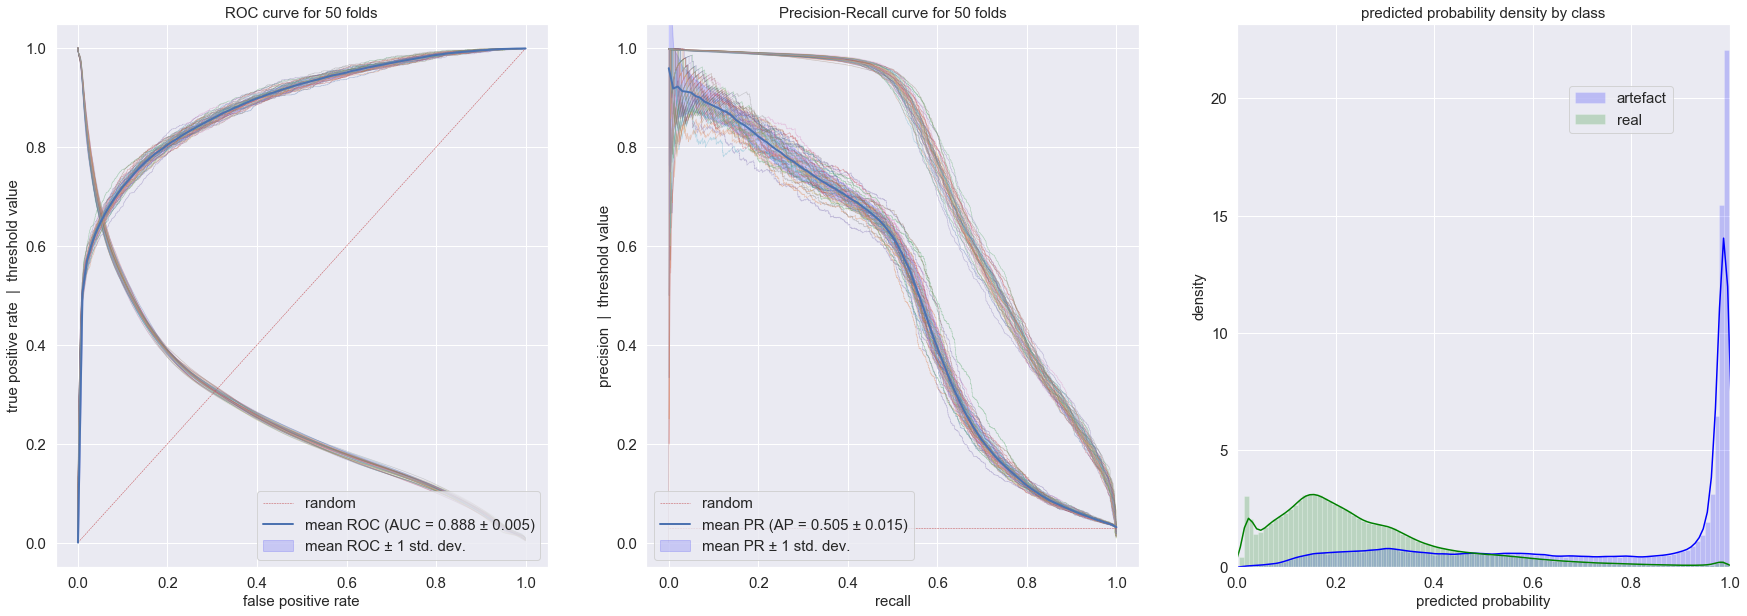

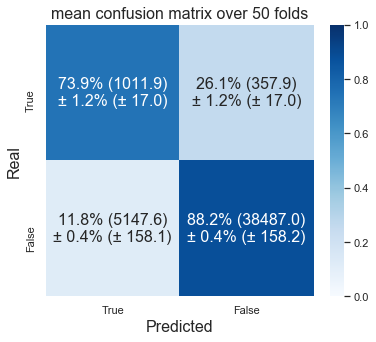

In [36]:
job_baseline.metrics.print_mean()
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_baseline.metrics.plot_mean_confusion_matrix()

# GroupKFold with group = `mut_key`

In [23]:
group_mut_key = data.get_original_impact()['mut_key']

In [24]:
job_mut_key = Selene_Job('gkf_mut_key')
job_mut_key.load_data(X, y, groups=group_mut_key)

➞ mkdir on local computer ssh_remote_jobs/job_gkf_mut_key


<span style="color:green">Job < gkf_mut_key >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_mut_key
➞ save groups.pkl in ssh_remote_jobs/job_gkf_mut_key


<span style="color:green">Job < gkf_mut_key >: </span>✅ data loaded

In [25]:
job_mut_key = Selene_Job('gkf_mut_key', load_from_id=True)

<span style="color:green">Job < gkf_mut_key >: </span>✅ job found and reloaded

In [26]:
%%writefile {job_mut_key.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
groups = pd.read_pickle('groups.pkl')

# set cross-validation
from sklearn.model_selection import GroupKFold
cv_strategy = GroupKFold(n_splits=5)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=7, n_estimators=500, learning_rate=0.02))
metrics = Metrics(model, X, y, cv_strategy, groups=groups, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_gkf_mut_key/script.ipy


In [27]:
job_mut_key.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_gkf_mut_key to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_mut_key
groups.pkl                                    100% 6765KB  12.4MB/s   00:00    
script.ipy                                    100% 1120   118.8KB/s   00:00    
X.pkl                                         100%   50MB  12.4MB/s   00:04    
y.pkl                                         100% 3736KB  16.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_mut_key
Job <30735536> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_mut_key -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < gkf_mut_key >: </span>✅ submitted<br>

In [37]:
job_mut_key.get_results()

<span style="color:green">Job < gkf_mut_key >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_mut_key to ssh_remote_jobs/job_gkf_mut_key
metrics.pkl                                   100% 7470KB   8.3MB/s   00:00    
job_output.txt                                100% 1401     4.5KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.496 ± 0.029
▴ Mean roc_auc          : 0.882 ± 0.009
▴ Mean precision        : 0.162 ± 0.011
▴ Mean recall           : 0.734 ± 0.017
▴ Mean f1               : 0.266 ± 0.016
▴ Mean accuracy         : 0.877 ± 0.008


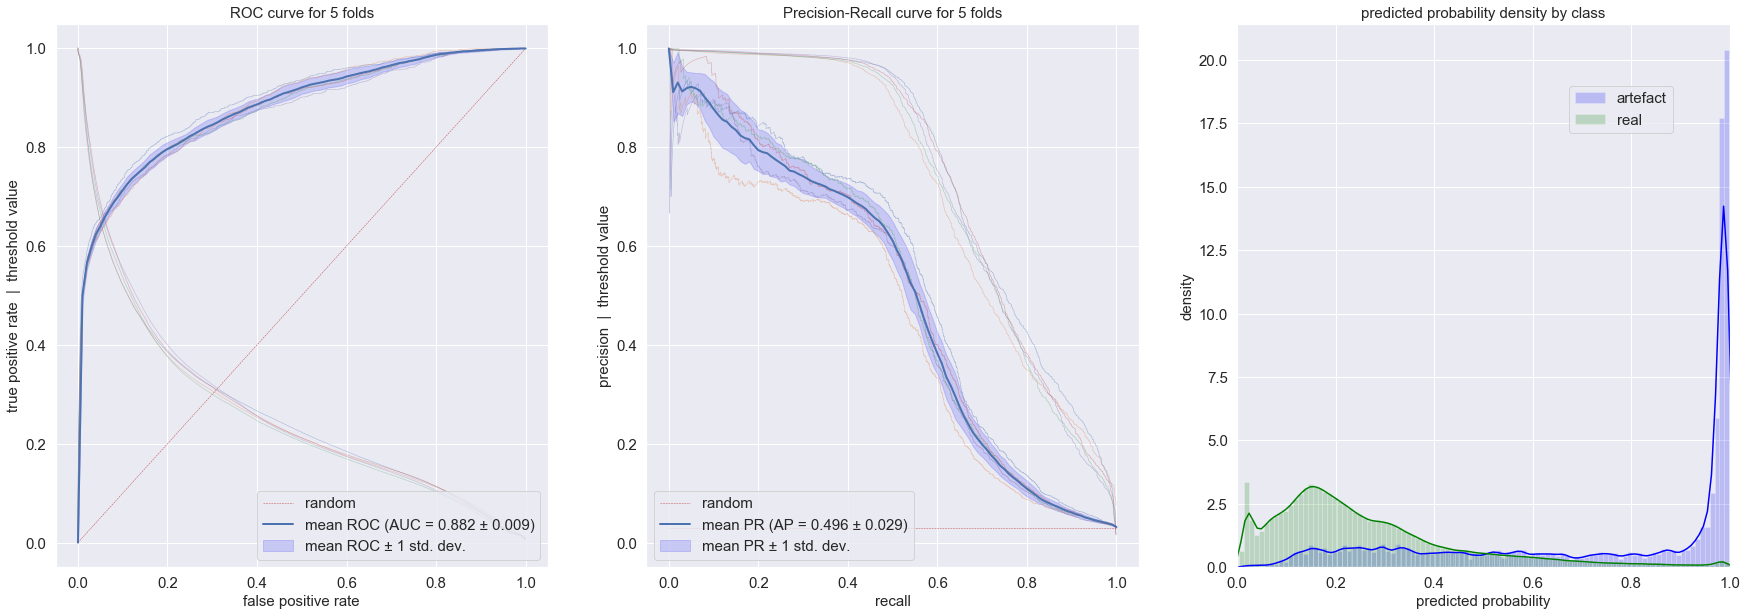

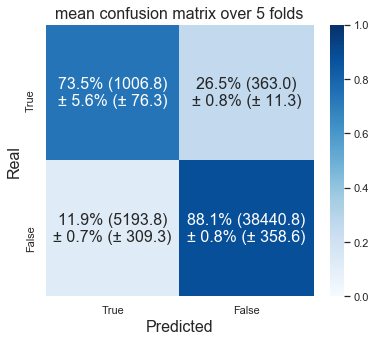

In [38]:
job_mut_key.metrics.print_mean()
job_mut_key.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_mut_key.metrics.plot_mean_confusion_matrix()

# GroupKFold with group = `patient_key`

In [29]:
group_patient_key = data.get_original_impact()['patient_key']

In [30]:
job_patient_key = Selene_Job('gkf_patient_key')
job_patient_key.load_data(X, y, groups=group_patient_key)

➞ mkdir on local computer ssh_remote_jobs/job_gkf_patient_key


<span style="color:green">Job < gkf_patient_key >: </span>✅ created

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_gkf_patient_key
➞ save groups.pkl in ssh_remote_jobs/job_gkf_patient_key


<span style="color:green">Job < gkf_patient_key >: </span>✅ data loaded

In [31]:
job_patient_key = Selene_Job('gkf_patient_key', load_from_id=True)

<span style="color:green">Job < gkf_patient_key >: </span>✅ job found and reloaded

In [32]:
%%writefile {job_patient_key.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')
groups = pd.read_pickle('groups.pkl')

# set cross-validation
from sklearn.model_selection import GroupKFold
cv_strategy = GroupKFold(n_splits=5)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=7, n_estimators=500, learning_rate=0.02))
metrics = Metrics(model, X, y, cv_strategy, groups=groups, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Writing ssh_remote_jobs/job_gkf_patient_key/script.ipy


In [33]:
job_patient_key.run(n_jobs=20, short_job=True)

➞ scp ssh_remote_jobs/job_gkf_patient_key to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_patient_key
groups.pkl                                    100% 4747KB  12.2MB/s   00:00    
script.ipy                                    100% 1120   142.9KB/s   00:00    
X.pkl                                         100%   50MB  13.6MB/s   00:03    
y.pkl                                         100% 3736KB  11.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_patient_key
Job <30735710> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J gkf_patient_key -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < gkf_patient_key >: </span>✅ submitted<br>

In [39]:
job_patient_key.get_results()

<span style="color:green">Job < gkf_patient_key >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/artefact_classification/ssh_remote_jobs/job_gkf_patient_key to ssh_remote_jobs/job_gkf_patient_key
metrics.pkl                                   100% 7527KB   5.5MB/s   00:01    
job_output.txt                                100% 1413    62.2KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.490 ± 0.037
▴ Mean roc_auc          : 0.873 ± 0.014
▴ Mean precision        : 0.160 ± 0.008
▴ Mean recall           : 0.710 ± 0.042
▴ Mean f1               : 0.260 ± 0.010
▴ Mean accuracy         : 0.877 ± 0.008


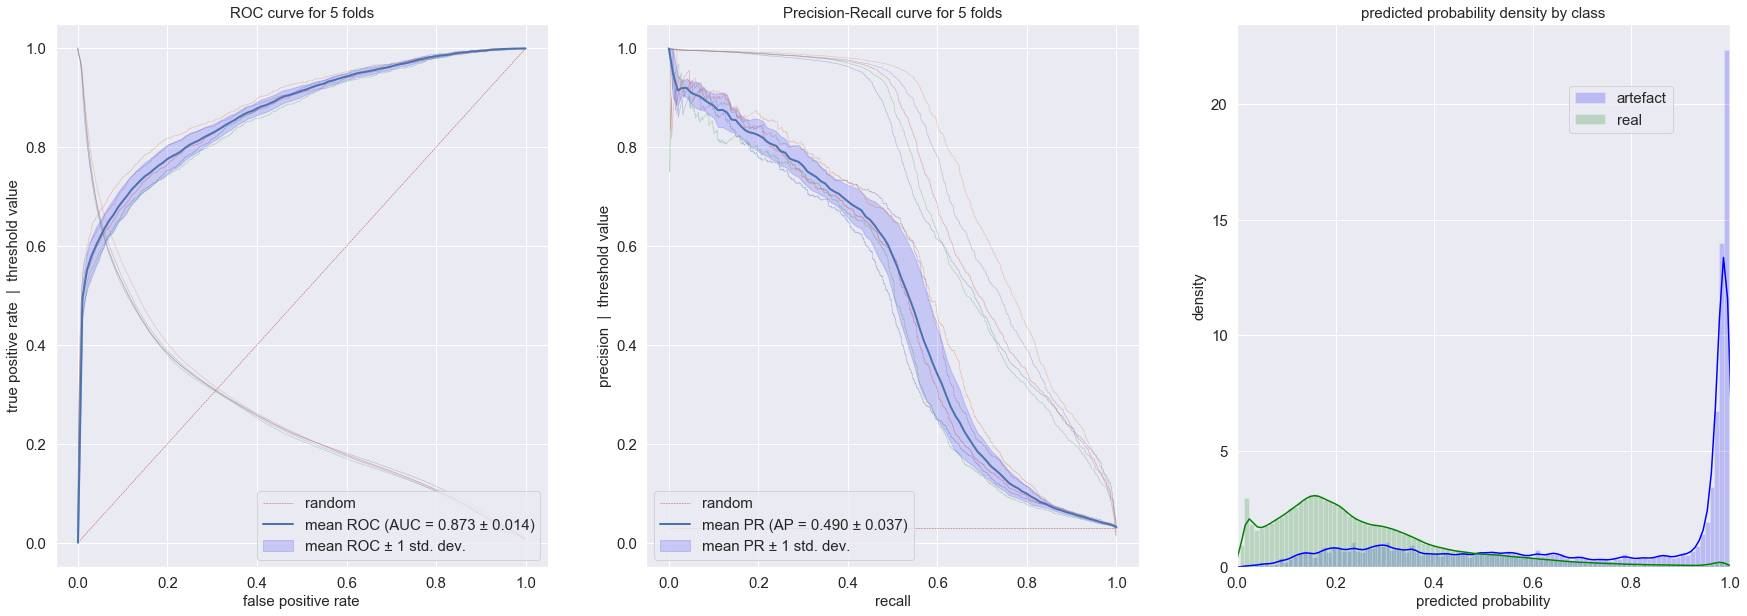

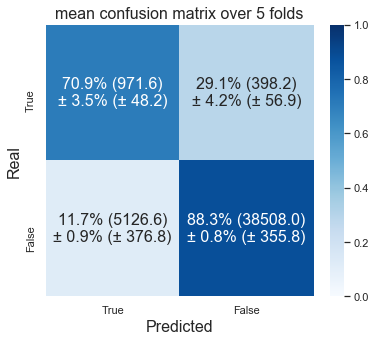

In [40]:
job_patient_key.metrics.print_mean()
job_patient_key.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_patient_key.metrics.plot_mean_confusion_matrix()

# Summary

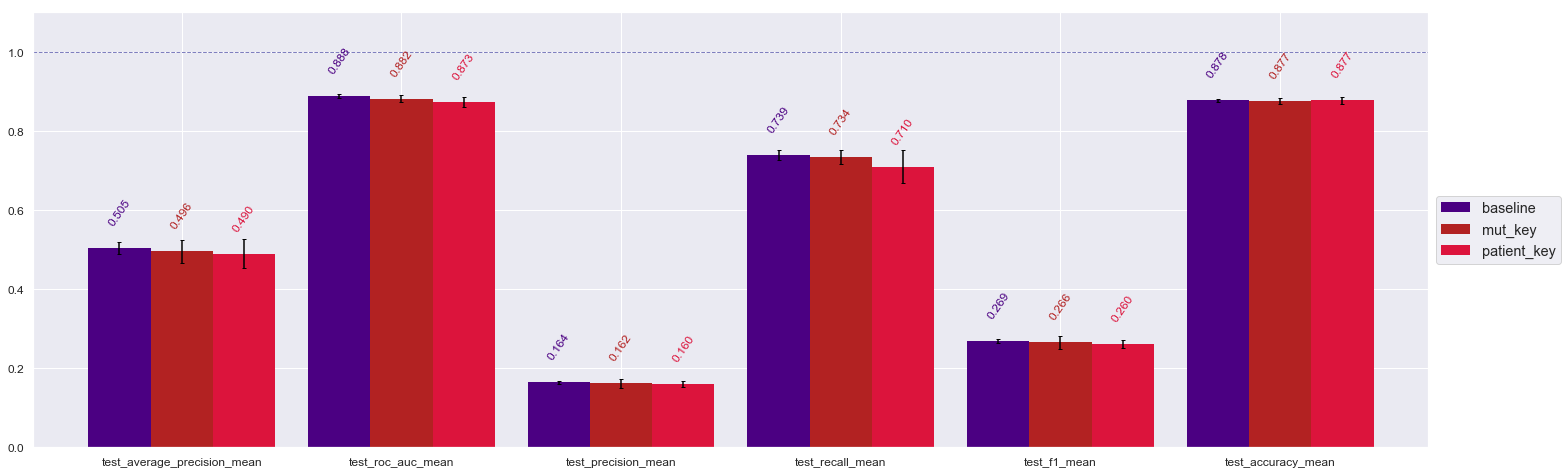

In [41]:
summary = Summary()
summary.add(job_baseline.metrics   , 'baseline'   , 'indigo')
summary.add(job_mut_key.metrics    , 'mut_key'    , 'firebrick')
summary.add(job_patient_key.metrics, 'patient_key', 'crimson')
summary.display()
summary.plot()